# Klasifikacija i klasteriranje prehrambenih proizvoda

U ovom projektu metodama klasifikacije provjerit ću može li se o nutritivnom
rezultatu proizvoda zaključiti na temelju njegovih sastojaka i imaju li kategorije prehrambenih proizvoda u trgovinama smisla metodama klasteriranja.

##Učitavanje potrebnih biblioteka
U prvom dijelu se učitavaju potrebne biblioteke i dohvaćaju podatci.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import boxcox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


Podatke učitavamo iz dataseta spremljenog na disku

In [ ]:
data = pd.read_csv("en.openfoodfacts.org.products.tsv",sep="\t")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##Upoznavanje sa datasetom

Dataset korišten u ovom projektu dio je dataseta preuzetog sa Open Food Facts. Link:  https://world.openfoodfacts.org/who-we-are
Podatke su prikupili razni volonteri iz cijelog svijeta, ali većinom iz Francuske. Podatke je moguće poslati preko web stranice ili mobilne aplikacije.





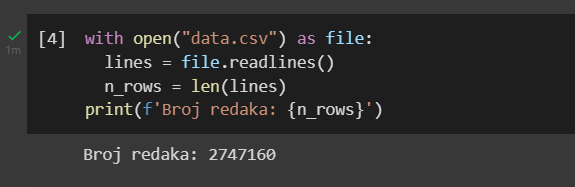

Potpuni dataset sadrži 2747160 podataka no u ovom projektu sam koristila njegovu skraćenu verziju koja se koristi i za Google Summer of Code i sadrži 356027 redaka i 163 stupca.


In [ ]:
data.shape

(356027, 163)

Projekt je započet u Francuskoj i većina podataka je iz Francuske i Sjedninjenih Američkih Država.

In [ ]:
dataC=data.groupby('countries_tags').size().sort_values(ascending = False).head(5)
dataC

countries_tags
en:united-states    173159
en:france           123960
en:switzerland       14932
en:germany            8470
en:spain              5529
dtype: int64

Prikaz najviše zastupljenih država u datasetu. Prikaz grafom i tablicom.



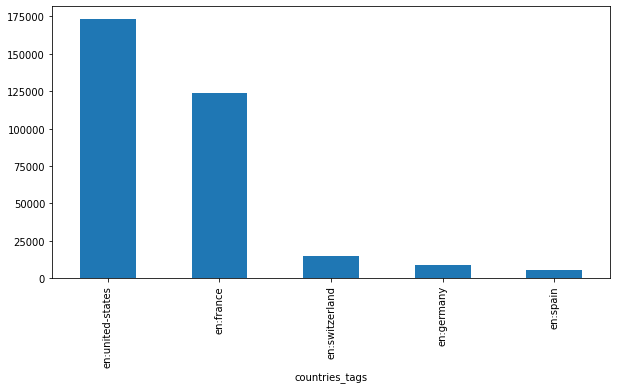

In [ ]:
dataC.plot(kind='bar',figsize=(10,5))


##Koji se sve podatci nalaze u datasetu?

Popis svih kolona u datasetu.

In [ ]:
print(data.columns.tolist())


['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

Možemo primijetiti da nam dosta podataka neće biti potrebno za predviđanja pa ćemo na početku izbaciti dio podataka.

Kako su podatke unosili sami korisnici dataset sadrži neke podatke o njima koje nam za potrebe projekta nisu bitne te ćemo ih izbaciti iz skupa podataka.

In [ ]:
data.drop(['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime'],axis=1,inplace=True)

In [ ]:
data.isna().sum()

product_name                17512
generic_name               298313
quantity                   236742
packaging                  266068
packaging_tags             266068
                            ...  
carbon-footprint_100g      355749
nutrition-score-fr_100g    101171
nutrition-score-uk_100g    101171
glycemic-index_100g        356027
water-hardness_100g        356027
Length: 156, dtype: int64

Primjećujemo da dosta stupaca ima veliki broj null vrijednosti pa isključujemo sve one koji se u velikom djelu sastoje od null vrijednosti.

In [ ]:
columns_with_data =[]
empty_cols=[]
for column in data.columns:
    if data[column].notnull().sum()> data.shape[0]*0.3:
        columns_with_data.append(column)
    else:
        empty_cols.append(column)


Nakon što smo odvojili stupce na one koji sadrže informacije, više od 70% vrijednosti različito od NaN pregledavamo koji su stupci ostali, a koji će biti odbačeni.

In [ ]:
print(empty_cols)

['generic_name', 'packaging', 'packaging_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'main_category', 'main_category_en', 'image_url', 'image_small_url', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', 'monou

Izbacivanje većinski praznih stupaca.

In [ ]:
data.drop(empty_cols,axis=1,inplace=True)

Pregledavanje preostalih stupaca i NaN vrijednosti u njima.

In [ ]:
data.isna().sum()

product_name                                17512
quantity                                   236742
brands                                      29050
brands_tags                                 29070
countries                                     275
countries_tags                                275
countries_en                                  275
ingredients_text                            72134
serving_size                               139406
additives_n                                 72160
additives                                   72202
additives_tags                             185838
additives_en                               185838
ingredients_from_palm_oil_n                 72160
ingredients_that_may_be_from_palm_oil_n     72160
nutrition_grade_fr                         101171
pnns_groups_1                              227021
pnns_groups_2                              223338
states                                         52
states_tags                                    52


#Klasifikacija

Nutri-Score je nutricionistička oznaka koja nutritivnu vrijednost proizvoda pretvara u jednostavan kod koji se sastoji od 5 slova, svako sa svojom bojom (tamno i svijetlo zelena, žuta, narančasta i crvena).
U ovom dijelu projekta pokušat ćemo klasificirati proizvode po njihovim nutritivnim vrijednostima u Nutri Score kategorije.

Iz potpunog seta podataka izdvojit ćemo one koji se odnose na nutritivne vrijednosti na 100g i one koji opisuju Nutri Score.

In [ ]:
dataNut=data[["energy_100g","fat_100g",
                        "saturated-fat_100g",
                        "carbohydrates_100g",
                        "sugars_100g",
                        "proteins_100g",
                        "salt_100g","product_name","nutrition_grade_fr","nutrition-score-fr_100g","nutrition-score-uk_100g",'pnns_groups_1']]

U podatcima se nalazi Nutri Score u Velikoj Britaniji i Francuskoj, međutim one se ne razlikuju u velikoj mjeri.

In [ ]:
(dataNut['nutrition-score-fr_100g']-dataNut['nutrition-score-uk_100g']).mean()

0.1854812129202373

In [ ]:
dataNut.drop(['nutrition-score-fr_100g','nutrition-score-uk_100g'],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Zbog toga ćemo koristit samo francusku verziju.

##Ispravljanje grešaka u datasetu

S obzirom da dataset ovisi o unosima korisnika moguće je da se potkradu neke greške .
Jedna od najčešćih je krivi unos vrijednosti energije zbog toga što se energija nekada mjeri u kJ, a ponekad u kalorijama.
Druga česta greška je ako je suma svih sastojaka veća od 100g po 100g.

In [ ]:
dataNut.isna().sum()

energy_100g            60660
fat_100g               76530
saturated-fat_100g     92204
carbohydrates_100g     76807
sugars_100g            76841
proteins_100g          61866
salt_100g              66288
product_name           17512
nutrition_grade_fr    101171
pnns_groups_1         227021
dtype: int64

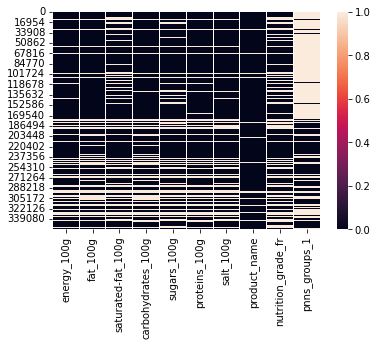

In [ ]:
sns.heatmap(dataNut.isna())

Iz data seta izbacujemo sve podatke za koje nemamo potpune informacije jer iz nepotpunih ne možemo zaključivati osim pnns jer je ona većinski prazna i ne koristimo je za klasifikaciju.

In [ ]:
dataNut.dropna(subset=dataNut.columns.difference(['pnns_groups_1']),axis=0, how="any", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
dataNut.shape

(235776, 10)

Preostali set podataka sadrži 10 stupaca i 235776 redaka.

Podatak koji fali na nutritivnim činjenicama je podatak o ostalim ugljikohidratima koji možemo dobiti iz podataka.

In [ ]:
dataNut["other_carbs"] = dataNut.carbohydrates_100g - dataNut.sugars_100g

<ipython-input-22-dbd3267de06f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNut["other_carbs"] = dataNut.carbohydrates_100g - dataNut.sugars_100g


Jedan od mogućih indikatora greške je ako je zbroj sastojaka u 100g veći od 100g.

In [ ]:
dataNut["g_sum"] =dataNut.fat_100g + dataNut.carbohydrates_100g +dataNut.proteins_100g + dataNut.salt_100g

<ipython-input-23-a32830d8db5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNut["g_sum"] =dataNut.fat_100g + dataNut.carbohydrates_100g +dataNut.proteins_100g + dataNut.salt_100g


In [ ]:
dataNut.g_sum[dataNut.g_sum > 100].count()

4146

Postoji 4146 podataka čije su vrijednosti krivo unesene.

Zbog grešaka u unosu ponovo ćemo izračunati energiju. Svaka kategorija ima odgovarajucu vrijednost u kJ.

In [ ]:
dataNut["reconstructed_energy"] = dataNut.fat_100g * 37 + (dataNut.proteins_100g + dataNut.carbohydrates_100g)* 17

<ipython-input-25-ebda181065c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNut["reconstructed_energy"] = dataNut.fat_100g * 37 + (dataNut.proteins_100g + dataNut.carbohydrates_100g)* 17


Novi izračun energije trebao bi biti bliži stvarnom stanju.

## Kodiranje Nutri Score-a

Provjerimo koje sve klase vrijednosti imamo.

In [ ]:
dataNut['nutrition_grade_fr'].unique()


array(['d', 'b', 'c', 'a', 'e'], dtype=object)

Vrijednosti NutiScora odgovaraju 5 očekivanih kategorija i nan kategoriju o kojoj nemamo podataka. Pa ćemo se riješiti podataka koji nisu potpuni.

In [ ]:
dataNut.dropna(subset = ['nutrition_grade_fr'],inplace=True)


Zatim ćemo podatke koji su prikazani slovima prebaciti u redne brojeve kategorija.

In [ ]:
dataNut.nutrition_grade_fr.unique()
target = []

for row in dataNut['nutrition_grade_fr']:
    if row == "a" :    target.append(1)
    elif row == "b":   target.append(2)
    elif row == "c":   target.append(3)
    elif row == "d":   target.append(4)
    elif row == "e":  target.append(5)

dataNut['target'] = target

<ipython-input-28-134caddb855e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNut['target'] = target


Svaku abecednu vrijednost smo zamijenili odgovarajućim brojem.

## Izbacivanje vrijednosti koje sadrže greške

Zadana provjera kojom izbacujemo vrijednosti koje u sebi imaju pogreške, ranije spomenute proizvode koji na 100g imaju više od 100g, kao i one koje u bilo kojoj kategoriji po 100g imaju više od 100g sastojka. Sljedeći podatci s greškom su oni koji imaju veću vrijednost šećera, koji su potkategorija ugljikohidrata nego ukupne količine ugljikohidrata. Zadnja vrsta podataka s greškom su oni kojima je energija veća od 3700 kJ što je vrijednost energije 100g masti.

In [ ]:
dataNut.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'product_name',
       'nutrition_grade_fr', 'pnns_groups_1', 'other_carbs', 'g_sum',
       'reconstructed_energy', 'target'],
      dtype='object')

In [ ]:
for col in dataNut.columns:
    if col not in ["energy_100g", "reconstructed_energy","product_name","target","nutrition_grade_fr",'pnns_groups_1']:
        dataNut = dataNut.loc[dataNut[col] <= 100]
    if col not in ["nutrition_grade_fr", "product_name", "target",'pnns_groups_1']:
        dataNut = dataNut.loc[dataNut[col] >= 0]

dataNut = dataNut.loc[dataNut.reconstructed_energy <= 3700]
dataNut = dataNut.loc[dataNut.carbohydrates_100g >= dataNut.sugars_100g]
dataNut = dataNut.loc[dataNut.g_sum <= 100]

Nakon kodiranja možemo izbaciti vrijednosti koje smo koristili za kontrole podataka kao i NutriScore i nutri grade na 100g.

In [ ]:
dataNut.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'product_name',
       'nutrition_grade_fr', 'pnns_groups_1', 'other_carbs', 'g_sum',
       'reconstructed_energy', 'target'],
      dtype='object')

Iz podataka izdvajamo set za klasteriranje koji će se koristiti kasnije i dijelimo set za klasifikaciju na dio za predviđanje i dio za validaciju.

In [ ]:
dataNutCluster=dataNut[[ 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'product_name',
        'pnns_groups_1', 'other_carbs',
       'reconstructed_energy']]

In [ ]:
dataNut.drop([ 'nutrition_grade_fr', 'g_sum','energy_100g','pnns_groups_1'], axis='columns',inplace=True)
classifying_table = dataNut[[ "product_name", "target"]]
nutrition_table1 = dataNut.drop(["product_name", "target"], axis='columns')

Pregled raspona vrijednosti preostalih stupaca

In [ ]:
dataNut

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,product_name,other_carbs,reconstructed_energy,target
1,28.57,28.57,64.29,14.29,3.57,0.00000,Banana Chips Sweetened (Whole),50.00,2210.71,4
2,17.86,0.00,60.71,17.86,17.86,0.63500,Peanuts,42.85,1996.51,2
3,57.14,5.36,17.86,3.57,17.86,1.22428,Organic Salted Nut Mix,14.29,2721.42,4
7,18.75,4.69,57.81,15.62,14.06,0.13970,Organic Muesli,42.19,1915.54,3
12,36.67,5.00,36.67,3.33,16.67,1.60782,Zen Party Mix,33.34,2263.57,4
...,...,...,...,...,...,...,...,...,...,...
355980,0.00,0.00,0.00,0.00,0.00,0.00000,Fairy Tail,0.00,0.00,2
355981,22.00,9.00,60.00,27.00,8.00,0.28000,"Biscuits aux céréales, aux pépites de chocolat...",33.00,1970.00,4
355985,0.00,0.00,87.06,2.35,1.18,0.03048,Natural Cassava,84.71,1500.08,1
356005,2.80,0.60,74.80,2.60,13.00,0.68000,Tartines craquantes bio au sarrasin,72.20,1596.20,1


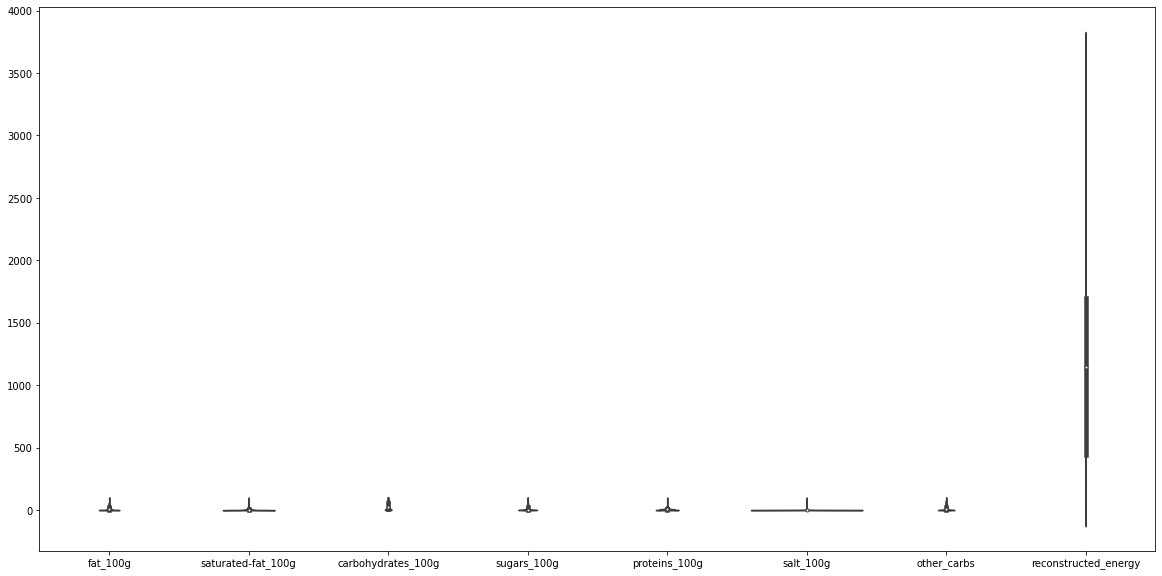

In [ ]:
plt.figure(figsize=(20,10))
sns.violinplot(data=nutrition_table1)


Primjećujemo da su podatci u različitim skalama, probleme nam stvara energija. Njezina vrijednost je mnogo veća nego ostale i zbog toga ćemo skalirati podatke. Kako bi pokazali razliku skaliranih i neskaliranih podataka algoritme ćemo pokrenuti na oba seta i usporediti rezultate.

In [ ]:
from sklearn import preprocessing

nutrition_table = preprocessing.normalize(nutrition_table1, axis=0)


U nutrition table su spremljeni normalizirani, a u nutrition_table1 originalni podatci.

Normalizacija značajki

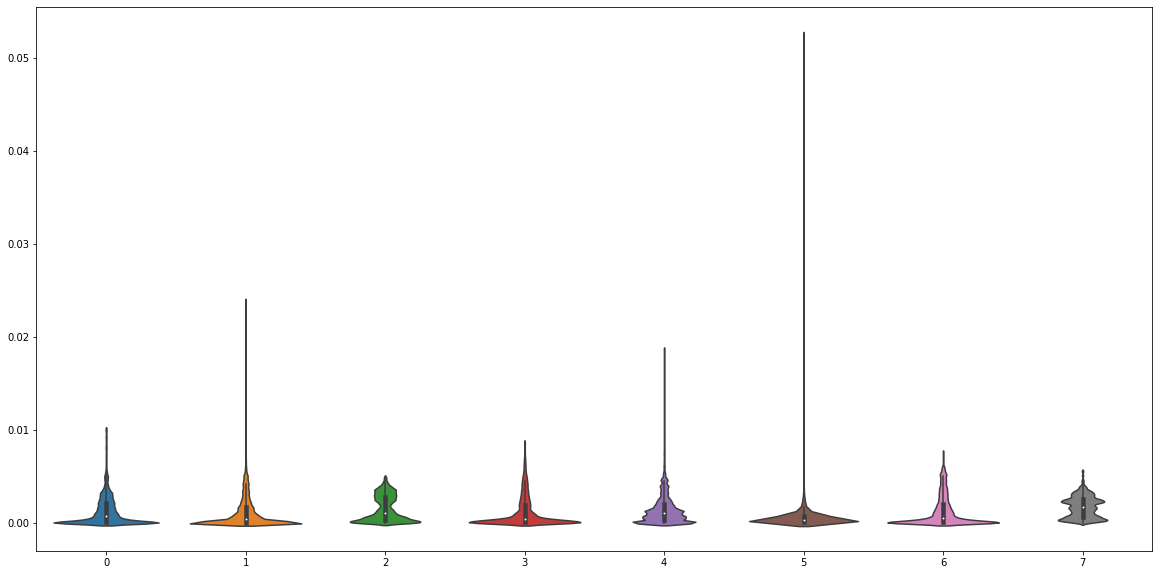

In [ ]:
plt.figure(figsize=(20,10))

sns.violinplot(data=nutrition_table)
plt.show()


Podatci su sada skalirani i imamo dosta outliera, ali nam to ima smisla jer je riječ o nutritivnim tablicama i npr. količina soli u većini hrane nije velika ali u grickalicama jest.

Odvajanje podataka na setove za treniranje i evaluaciju

In [ ]:
classifying_table_train, classifying_table_test, nutrition_table_train, nutrition_table_test = train_test_split(classifying_table, nutrition_table, test_size=0.3, random_state=0)
classifying_table_train1, classifying_table_test1, nutrition_table_train1, nutrition_table_test1 = train_test_split(classifying_table, nutrition_table1, test_size=0.3, random_state=0)


In [ ]:
nutrition_table_train1.shape

(161711, 8)

Svi podatci koji se odnose na nenormalizirane podatke označeni su s 1.

Postavljamo vrijednost po kojoj želimo klasificirati na stupac target.

In [ ]:
train = classifying_table_train["target"]

## Određivanje najbolje vrijednost k
Prva metoda klasifikacije je KNN i za nju prvo trebamo podesiti vrijednost k. Postavljanjem vrijednosti od 1,15 dobivamo graf performansi našeg modela ovisan o različitom k. Tražimo k s najmanjom greškom.

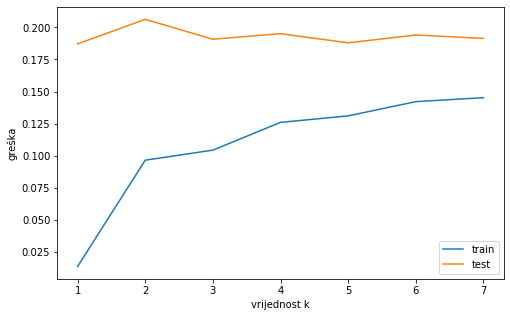

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

error1= []
error2= []

for k in range(1,8):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(nutrition_table_train, train)
    y_pred1= knn.predict(nutrition_table_train)
    error1.append(np.mean(train!= y_pred1))
    y_pred2= knn.predict(nutrition_table_test)
    error2.append(np.mean(classifying_table_test["target"]!= y_pred2))

plt.figure(figsize=(8,5))
plt.plot(range(1,8),error1,label="train")
plt.plot(range(1,8),error2,label="test")
plt.xlabel('vrijednost k')
plt.ylabel('greška')
plt.legend()

Primjećujemo da je vrijednost mala oko 3 i 5 i nakon unošenja obje mogućnnosti u model odlučujemo se za 5.

##Inicijalizacija modela

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn1=KNeighborsClassifier(n_neighbors=5)

Fittanje modela

In [ ]:
knn.fit(nutrition_table_train, train)

KNeighborsClassifier()

In [ ]:
knn1.fit(nutrition_table_train1, train)

KNeighborsClassifier()

##Evaluacija i usporedba

In [ ]:
k=knn.score(nutrition_table_test, classifying_table_test["target"])

In [ ]:
k1=knn1.score(nutrition_table_test, classifying_table_test["target"])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
dataTable = [['normal',k], ['original', k1]]

df = pd.DataFrame(dataTable, columns=['data', 'Score'])

# print dataframe.
df

,data,Score
0,normal,0.812036
1,original,0.132095


U tablici vidimo da je uspjeh modela s normaliziranim podatcima značajno veći i da je zadovoljavajuć.

##Matrica konfuzije za normalizirane podatke

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(nutrition_table_test)
confusion_matrix(classifying_table_test["target"],y_pred)
pd.crosstab(classifying_table_test["target"], y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,All
True,,,,,,
1,9492,1358,279,27,25,11181
2,1506,7934,1161,96,118,10815
3,371,1416,11062,1643,85,14577
4,63,172,1623,16625,1134,19617
5,94,248,196,1412,11166,13116
All,11526,11128,14321,19803,12528,69306


U matrici konfuzije vidimo da je u velikom broju slučaja broj ispravno pogođenih vrijednosti za red veličine veći od onih koje nisu pogođene.

##Procjena rezultata 2

Precision označava postotak koji dobijemo kad podijelimo točno predviđene sa svim koje smo predvidjeli kao dio te klase. Recall označava omjer točno predviđenih i onih koji su pripadali klasi, ali ih nismo prepoznali. f1 uzima u obzir preciznost i osjetljivost te pronalazi njihovu sredinu.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(classifying_table_test["target"], y_pred))

              precision    recall  f1-score   support

           1       0.82      0.85      0.84     11181
           2       0.71      0.73      0.72     10815
           3       0.77      0.76      0.77     14577
           4       0.84      0.85      0.84     19617
           5       0.89      0.85      0.87     13116

    accuracy                           0.81     69306
   macro avg       0.81      0.81      0.81     69306
weighted avg       0.81      0.81      0.81     69306



##Slučajna suma
Kao i kod KNN provodimo model s originalnim i normaliziranim podatcima, ali ovdje ne očekujemo velike razlike zato što model sam određuje težinske faktore.

## Traženje optimalnih hiperparametara za slučajnu šumu

Optimalne paramtere tražimo tako da pomoću Grid Searcha ispitujemo sve kombinacije, ovaj dio koda je zakomentiran jer jako dugo traje.


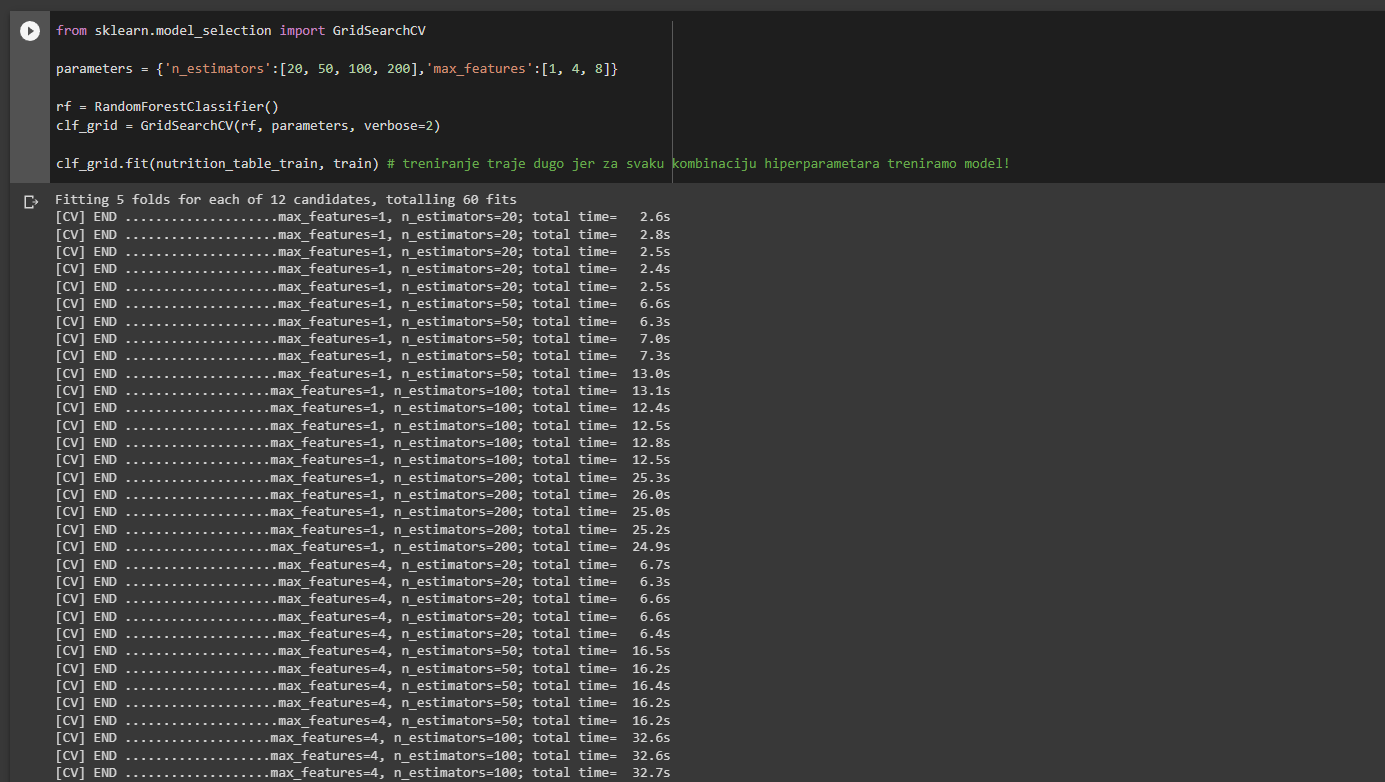

In [ ]:
#  from sklearn.model_selection import GridSearchCV

# parameters = {'n_estimators':[20, 50, 100, 200],'max_features':[1, 4, 8]}

# rf = RandomForestClassifier()
# clf_grid = GridSearchCV(rf, parameters, verbose=2)

# clf_grid.fit(nutrition_table_train, train) # treniranje traje dugo jer za svaku kombinaciju hiperparametara treniramo model!

##Najbolji set parametara
Ova naredba je zakomentirana jer ovisi o izvođenju prošle i kada se pokrene daje vrijednosti n_estimators=200,max_features=4. To su vrijednosti koje ćemo koristiti za naše modele slučajne sume.

In [ ]:
# print(clf_grid.best_params_)

##Primjena modela sa najboljom kombinacijom parametara

In [ ]:
rf = RandomForestClassifier(n_estimators=200,max_features=4, oob_score=True, random_state=42)
rf.fit(nutrition_table_train, train)

RandomForestClassifier(max_features=4, n_estimators=200, oob_score=True,
                       random_state=42)

In [ ]:
rf1 = RandomForestClassifier(n_estimators=200,max_features=4, oob_score=True, random_state=42)
rf1.fit(nutrition_table_train1, train)

RandomForestClassifier(max_features=4, n_estimators=200, oob_score=True,
                       random_state=42)

##Evaluacija rezultata i usporedba

In [ ]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(nutrition_table_test)
accuracy = accuracy_score(classifying_table_test["target"], predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.867
Mean accuracy score: 0.864


In [ ]:
predicted1 = rf1.predict(nutrition_table_test1)
accuracy = accuracy_score(classifying_table_test["target"],predicted1)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.867
Mean accuracy score: 0.864


Nema razlike u rezultatima između slučajne šume s normaliziranim i nenormaliziranim podatcima. Sveukupni rezultat nešto je bolji nego kod KNN.

Važnost pojedinih parametara modela slučajne šume moguće je provjeriti korištenjem podataka o težinskim vrijednostima.

In [ ]:
rf.feature_importances_


array([0.09265514, 0.19473111, 0.06305739, 0.16007181, 0.09970303,
       0.21997521, 0.06433297, 0.10547335])

In [ ]:
rf1.feature_importances_

array([0.09099426, 0.19694793, 0.06336927, 0.15939364, 0.09960068,
       0.22037494, 0.06298121, 0.10633808])

Za razliku od modela k najbližih susjeda kod slučajne šume nema velike razlike koristimo li normalizirane podatke ili ne.

Kako bismo bolje razumjeli model vizualiziramo što je najviše utjecalo na klasifikaciju.

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

Text(0.5, 0, 'Random Forest Feature Importance')

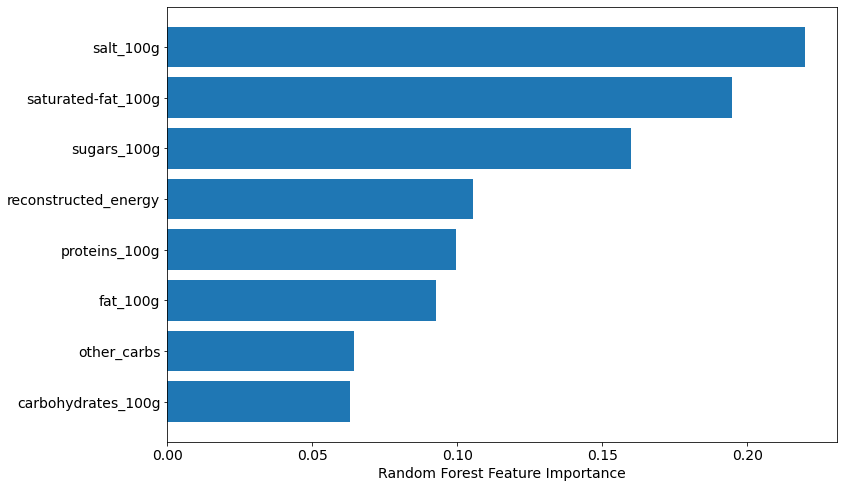

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(nutrition_table1.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Rezultati imaju smisla jer sol, zasićene masti i šećer jesu ono po čemu kategoriziramo hranu kao nezdravu.

###Sljedeći koraci
Kako bismo procjenili rezultate produkcije odabrali bismo još jedan set podataka koji se nisu koristili do sada ni za train ni test da vidimo je li naš model stvarno toliko dobar ili je riječ o overfittingu na naše podatke.

#Klasteriranje

Podatcima u velikoj mjeri fali infomacija kojoj glavnoj grupi proizvoda pripadaju. Prilikom odlaska u dućan hrana je grupirana u neke kategorije pa ćemo pomoću algoritama za klasteriranje pokušati dobiti neke smislene grupe proizvoda. Pri odlasku u trgovinu to su neke od ovih.



*  PEKARSKI PROIZVODI
*  VOĆE, POVRĆE I ORAŠASTI PLODOVI
*  MLIJEČNI PROIZVODI
*  JAJA I SIR
*  SVJEŽE MESO I RIBA
*  MESNE DELIKATESE
*  VODA I LED
*  SLATKIŠI I GRICKALICE
*  OSNOVNE NAMIRNICE
*  UMACI I ZAČINI
*  PAHULJICE I NAMAZI

Pregled podataka koje koristimo za klasteriranje.

In [ ]:
from spacy.lang.fr import stop_words

In [ ]:
dataNutCluster

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,product_name,pnns_groups_1,other_carbs,reconstructed_energy
1,28.57,28.57,64.29,14.29,3.57,0.00000,Banana Chips Sweetened (Whole),NaN,50.00,2210.71
2,17.86,0.00,60.71,17.86,17.86,0.63500,Peanuts,NaN,42.85,1996.51
3,57.14,5.36,17.86,3.57,17.86,1.22428,Organic Salted Nut Mix,NaN,14.29,2721.42
7,18.75,4.69,57.81,15.62,14.06,0.13970,Organic Muesli,NaN,42.19,1915.54
12,36.67,5.00,36.67,3.33,16.67,1.60782,Zen Party Mix,NaN,33.34,2263.57
...,...,...,...,...,...,...,...,...,...,...
355980,0.00,0.00,0.00,0.00,0.00,0.00000,Fairy Tail,unknown,0.00,0.00
355981,22.00,9.00,60.00,27.00,8.00,0.28000,"Biscuits aux céréales, aux pépites de chocolat...",unknown,33.00,1970.00
355985,0.00,0.00,87.06,2.35,1.18,0.03048,Natural Cassava,NaN,84.71,1500.08
356005,2.80,0.60,74.80,2.60,13.00,0.68000,Tartines craquantes bio au sarrasin,Cereals and potatoes,72.20,1596.20


Podjela podataka na kategoričke i numeričke. Kategoričke izdvajamo iz skupa koji ćemo normalizirati.

In [ ]:
d=dataNutCluster.drop(['product_name','pnns_groups_1'],axis=1)
features=d.columns

Iz seta uklanjamo podatke koji nemaju podatak o grupi kako bismo si olakšali interpretaciju klastera.

In [ ]:
nutrition_table_Cluster=dataNutCluster
nutrition_table_Cluster.dropna(subset = ['pnns_groups_1'],inplace=True)


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Zatim podijelimo set na tablicu za test i trening.

In [ ]:
nutrition_tableC, test_tableC = train_test_split(nutrition_table_Cluster, test_size=0.3, random_state=0)


In [ ]:
X_train = nutrition_tableC[features]
X_test = test_tableC[features]

Iz podataka izdvojimo stupce koji su numerički kako bismo ih kasnije mogli normalizirati.

In [ ]:
print("Number of train samples: " + str(X_train.shape[0]))


Number of train samples: 65080


Normalizacija

In [ ]:
X_test1 = preprocessing.normalize(X_test, axis=0)

X_train1 = preprocessing.normalize(X_train, axis=0)

Treniranje modela

Klasteriramo proizvode u 10 klasa.

In [ ]:
components = 10

model = GaussianMixture(n_components=components,
                        covariance_type="full",
                        random_state=1,
                        n_init=1,
                        max_iter=200,
                        init_params="kmeans")
model.fit(X_train1)
print("Model converged: " + str(model.converged_))

nutrition_tableC["cluster"] = model.predict(X_train1)
test_tableC["cluster"] = model.predict(X_test1)

Model converged: True


Treniramo Gaussian Mixture model i provjeravamo jesmo li dobili model koji konvergira.

Funkcija koju koristimo za vizualizaciju najčešćih rijeci u imenima i kategorijama unutar pojedinog klastera.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

def make_word_cloud(data, cluster, subplotax, title):
    counter_words = Counter()

    words = data[data.cluster==cluster]["product"].apply(lambda l: l.lower().split())
    cluster_words=words.apply(pd.Series).stack().reset_index(drop=True)
    stop_words = stopwords.words('french')
    stop_words_2= stopwords.words('english')
    for word in cluster_words:
      if word not in stop_words and word.isalnum() and word.isnumeric()==False and  word not in stop_words_2:
        counter_words.update({word})

    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=40, max_words=30,
                          background_color="white", colormap="magma")
    wordcloud.generate_from_frequencies(counter_words)
    # Display the generated image:
    subplotax.imshow(wordcloud, interpolation='bilinear')
    subplotax.axis("off")
    subplotax.set_title(title)
    return subplotax


Pozivanje WordClouda za imena proizvoda koji će nam pomoći interpretirati naše klastere.

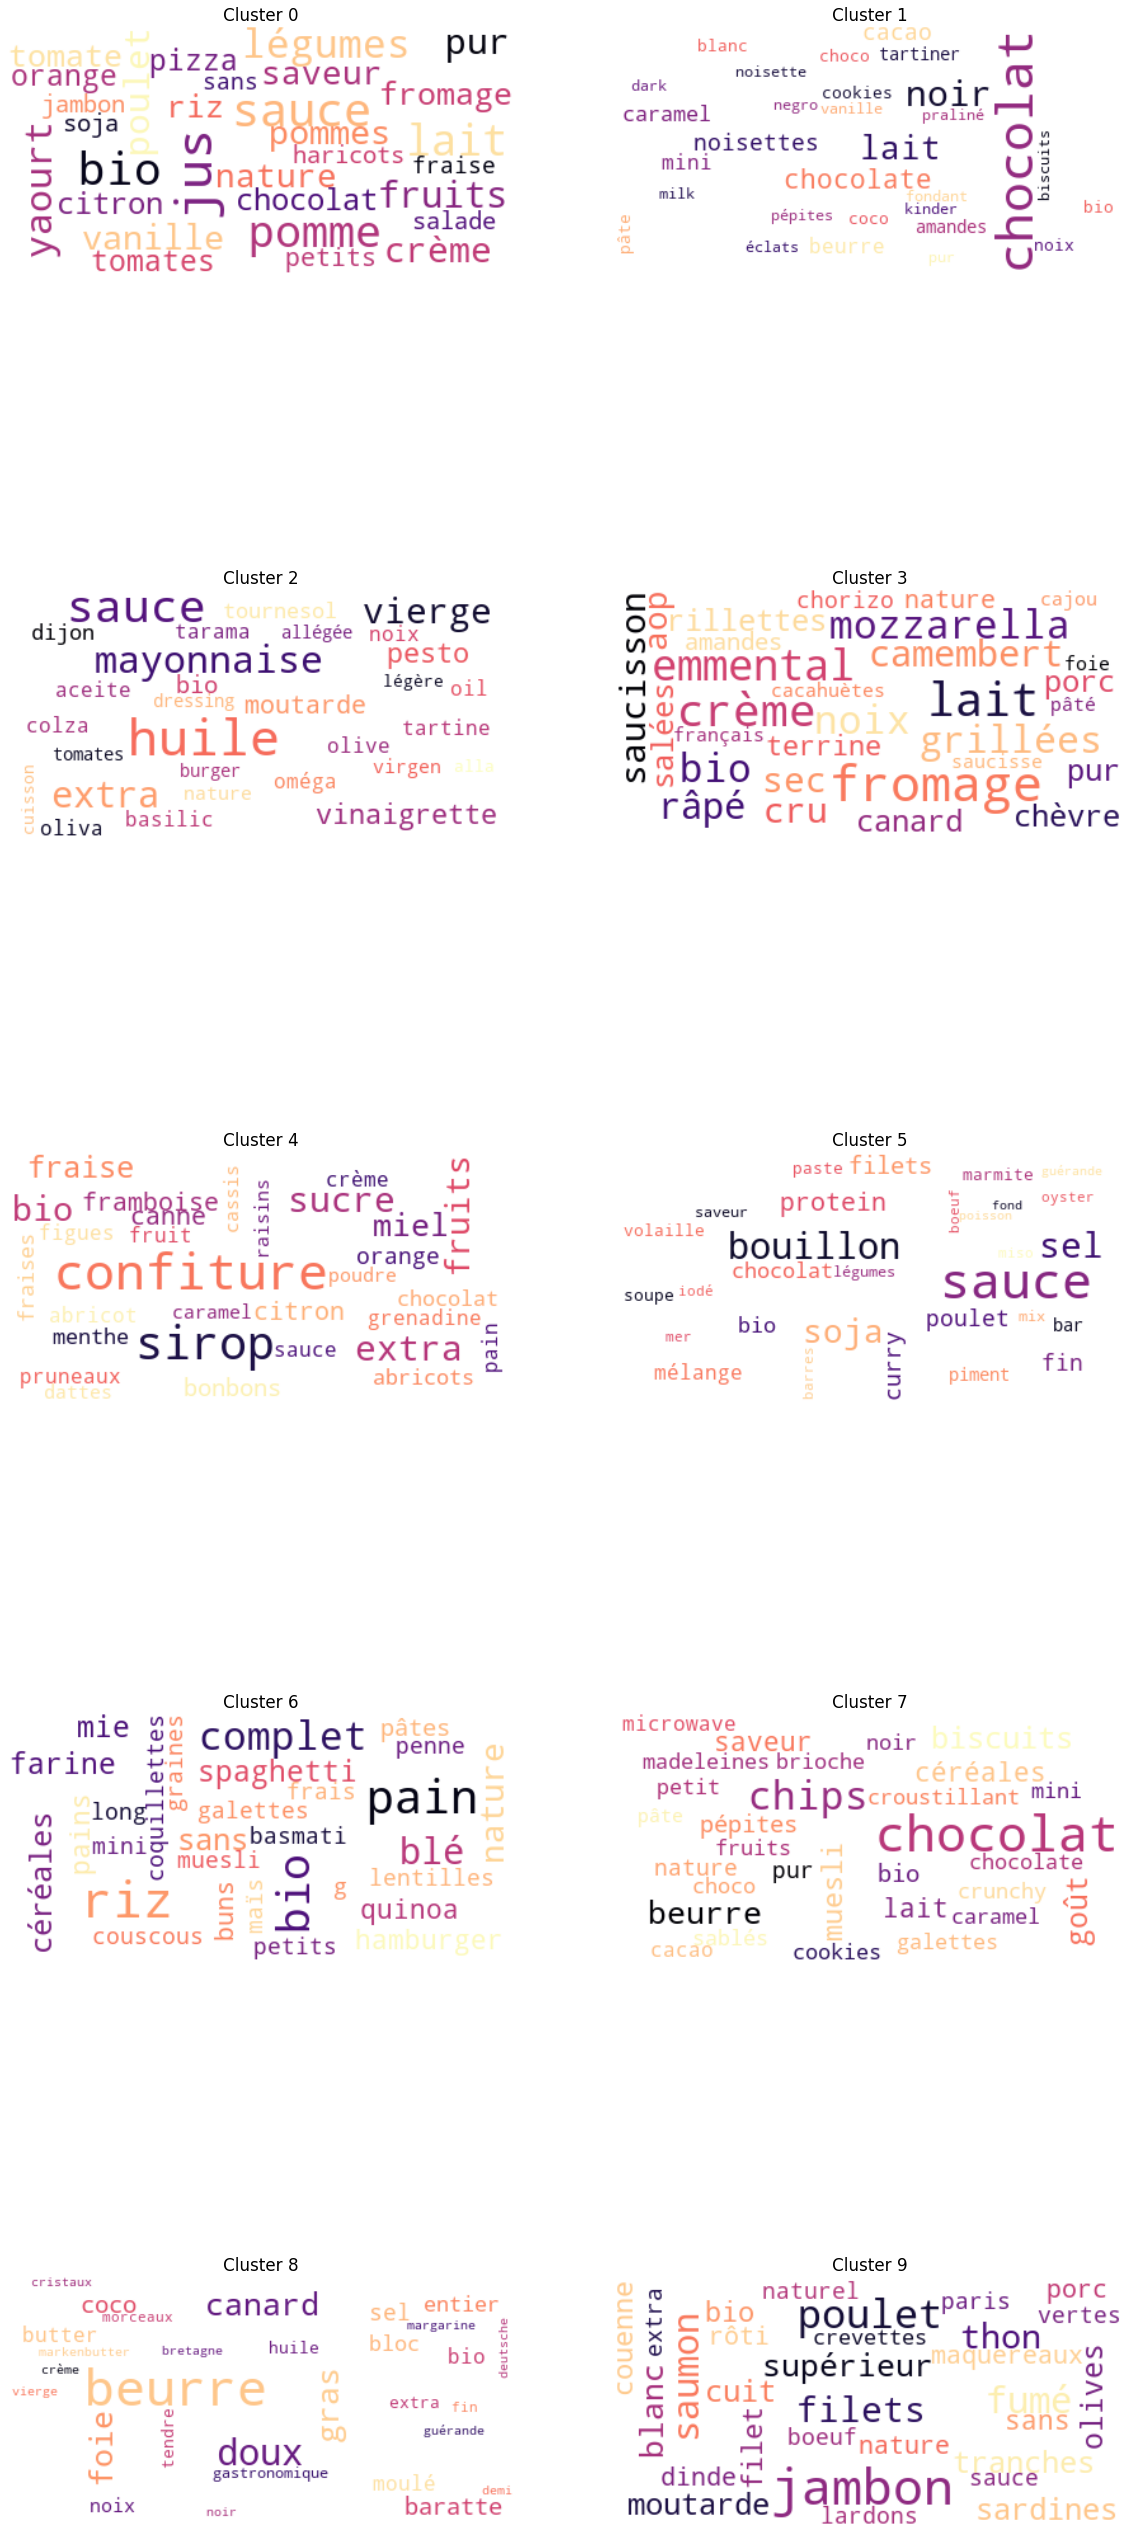

In [ ]:
nutrition_tableC["product"] = nutrition_tableC.loc[nutrition_tableC.index, "product_name"]

fig, ax = plt.subplots(5,2, figsize=(20,50))
for m in range(5):
    for n in range(2):
        cluster = m*2+ n
        title = "Cluster " + str(cluster)
        make_word_cloud(nutrition_tableC, cluster, ax[m,n], title)

Prijevod Francuskih riječi po Clusterima:

0. Voće, šunka, sir, Čokolada, riža, priroda, piletina, rajčica, jabuke, bez, umak, vanilija, limun, sok, jogurt, vrhnje, sviježe, jagoda, naranča, okus, čisti, bio, mali , soja, mahune


1. Tijesto, lješnjak, badem, vanilija, kakao, mlijeko, keksi, kokos, biskvit(druga vrsta keksa), kinder, čokoladan, mali maslac, namaz, crna čokolada, bijela, topljiva, pralina, crna čokolada, sa čokoladnim mrvicama

2. Senf, ulje, ekstra, djevičansko, aoli, omega, lagano, umak, majoneza, maslina, dijon senf, ljuto, suncokret, aceto balsamico, preljev za salatu, ocat, kanolino ulje, namaz od ribljih jaja sa pire krumpirom i octom (tarama)

3. Čisto, kobasica, španjolska kobasica, svinjetina, Camenbert, jetra, druga vrsta kobasice, mlijeko, mozzarela, pašteta, prženi, patka, krema, namaz, sir, francuski, suhi, izriban, slan, kozji, bio, meso u tegli napunjenoj masti, sirovo, oznaka kvalitete(kao npr. kupujmo hrvatsko ali njihova verzija)

4. Sirup, malina, kora cimeta, karamela, jagode, umak, limun, grožđice, marelica, menta, suhe šljive, naranče, voće, krema, šećer, marelica, datulje, ribzl, ekstra, smokve, med, u prehu, datulje


5. Od kamenica, umak, sol, mješano, miso, proteini, fileti, kokošji, papar, namaz od kvasca, riblji, okus mora, kocka za juhu, goveđi, provrtni, juha, riblji, perad, jodirano

6. Kvinoja, riza, tjestenina, musli, malo, kukuruz, zrnje, hamburger, lepinja, komplentni, prirodna, brašno, krekeri, kruh, cous cous, dugo, leća, pulpa od kruha, špageti, penne, malo, bez, basmati, žito, žitarice

7. Okus, čokolada, hrskavo, čips, mali kolačići, crno, maslac, okus, tijesto, tvrdi keksi, karamela, keksi sa komadićima čokolade, mikrovalna pečnica, keksi od prkhog tijesta

8. Mala regija u francuskoj poznata po maslacu, maslac sa dokazanim podrijelom, mala bačva za proizvodnju maslaca, mast, cijeli, margarin, ulje, patka, njemačko, gastronoski, slatko, blok, slano, mekano, bretanjski, krema, jetra, komadi, tanak

9. Kuhano, losos, ekstra, tuna, govedina, senf, pariz, senf, priroda, bolji, skuša, umak, zeleni, dimljena, kozica, fileti, pečenje, puretina, svinjska kožica

*Preveo Christian Šilović, student anglistike, francuskog jezika i književnosti*

Analizom i prevođenjem najčešćih riječi u pojedinom klasteru dobivamo više informacija kako je model podijelio podatke, ali za bolji prikaz kombiniramo s word cloudom grupa.

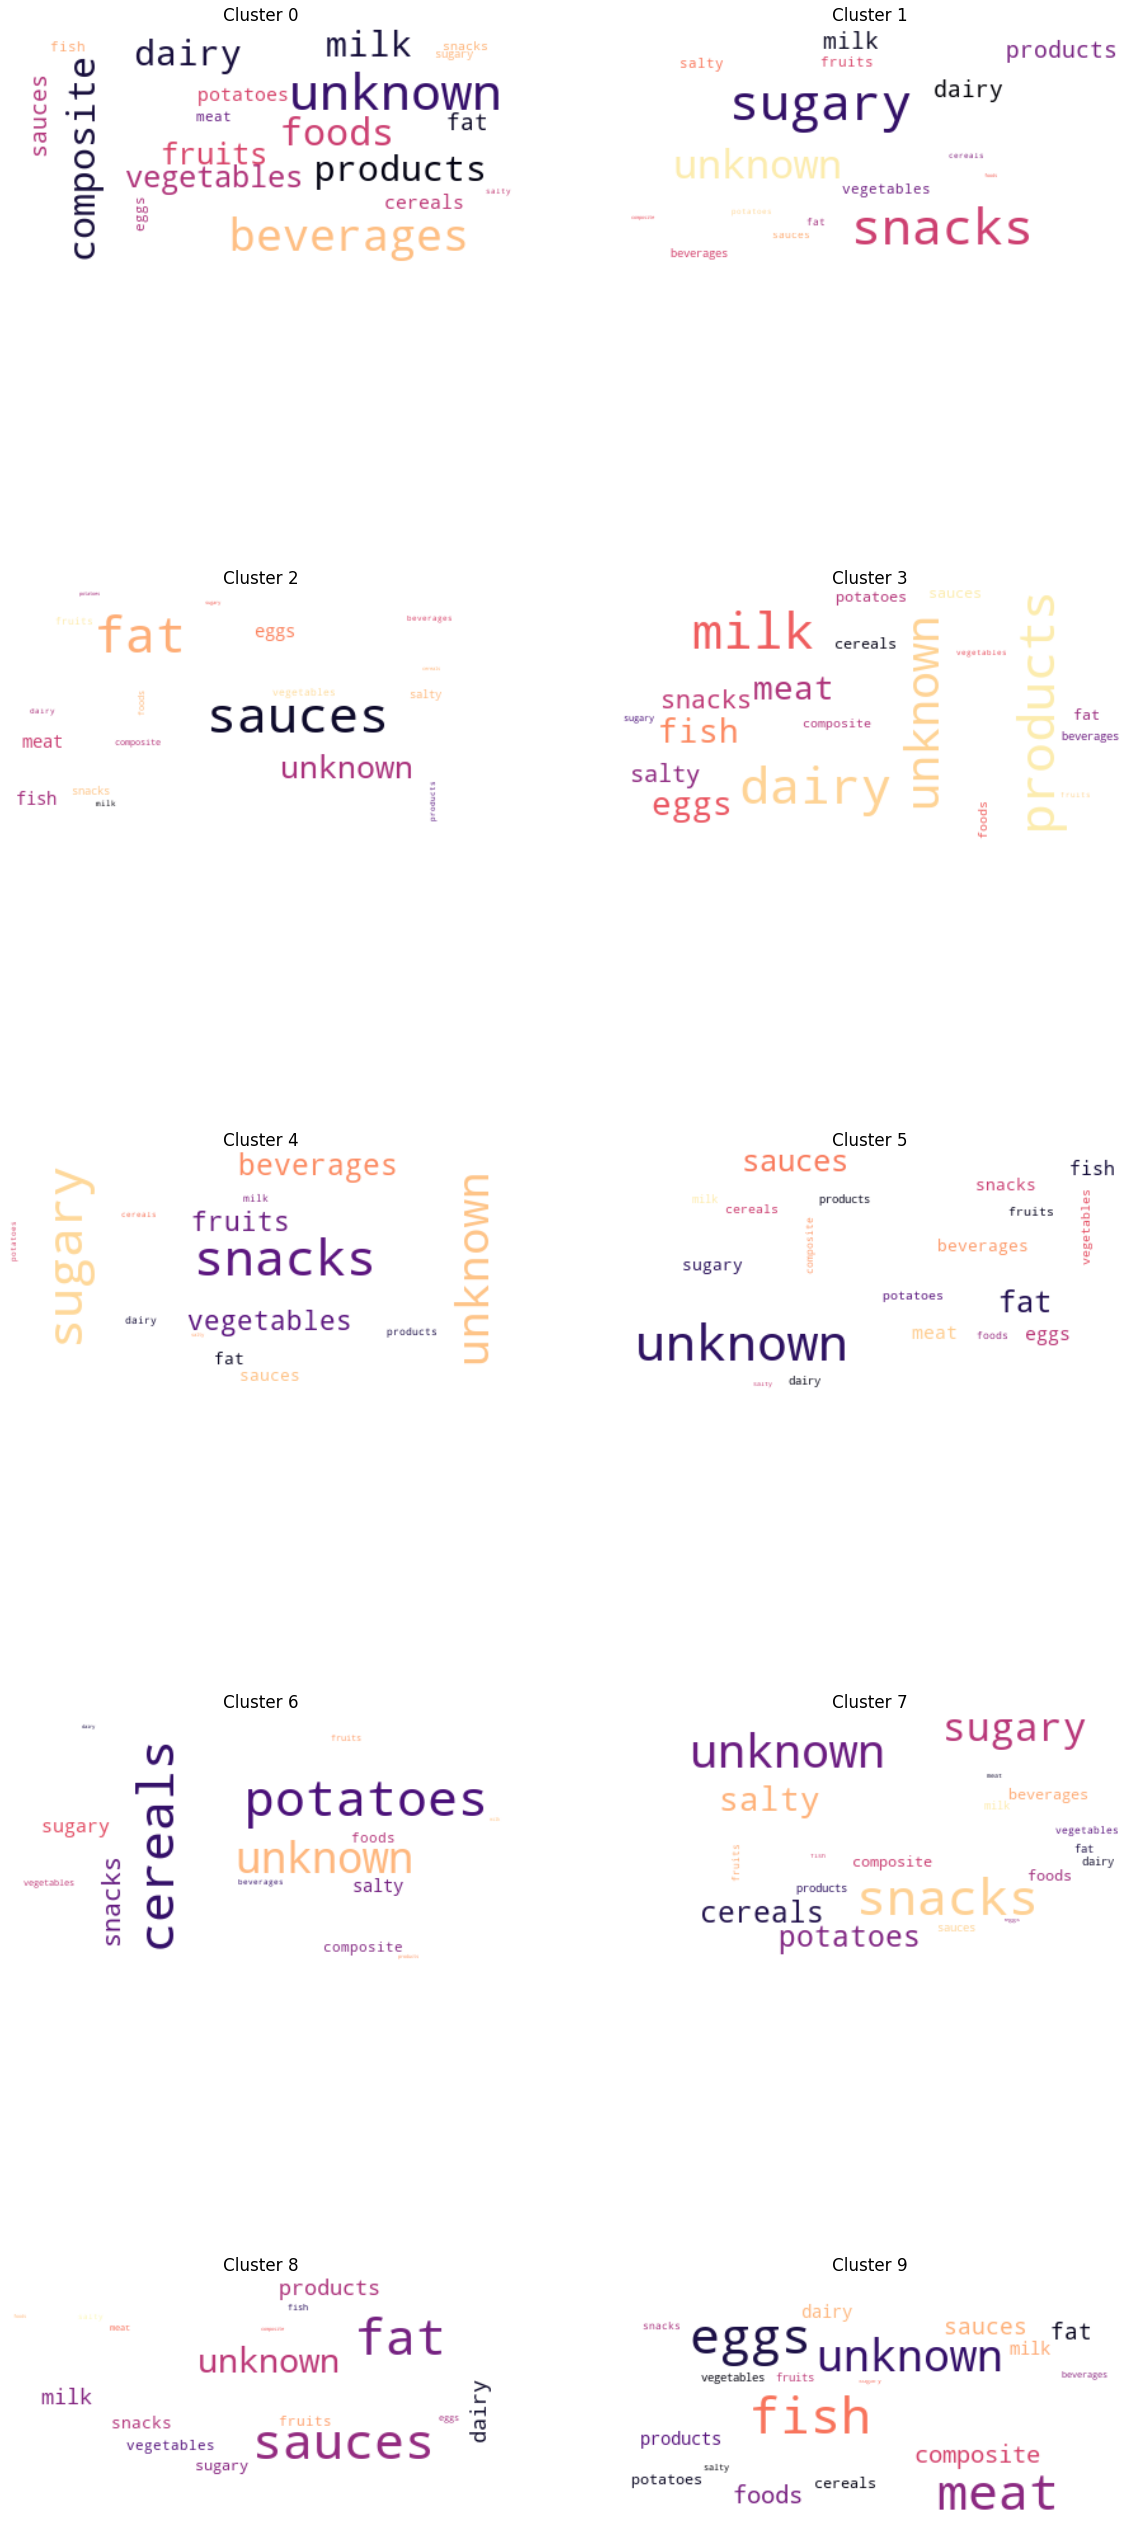

In [ ]:
nutrition_tableC["product"] = nutrition_tableC.loc[nutrition_tableC.index, "pnns_groups_1"]

fig, ax = plt.subplots(5,2, figsize=(20,50))
for m in range(5):
    for n in range(2):
        cluster = m*2+ n
        title = "Cluster " + str(cluster)
        make_word_cloud(nutrition_tableC, cluster, ax[m,n], title)

Iako je nepoznat dio kategorija u svakom clusteru, ključne riječi i dalje doprinose u boljem tumačenju dobijenih clustera.

Kombinacijom i analizom dolazimo do zaklučka o sadržaju svakog klastera

**Klaster 0**
* Prirodni proizvodi, voće, povrće

**Klaster 1**
* Čokolada i proizvodi sa čokoladom

**Klaster 2**
* Umaci, preljevi

**Klaster 3**
* Sir, mlijeko i mliječni proizvodi, naresci

**Klaster 4**
* Pekmezi i sirupi, sušeno voće

**Klaster 5**
* Paštete i osnove

**Klaster 6**
* Žitarice i kruh

**Klaster 7**
* Grickalice i keksi

**Klaster 8**
* Kuhana i složena jela

**Klaster 9**
* Meso, riba i jaja



## Sljedeći koraci
Unaprijeđenje metode klasteriranja i temeljitija analiza samih klastera

# Zaključak

Korištenjem podataka iz ovog dataseta možemo zaključiti o vrsti i nutritivnom rezultatu prehrembenog proizvoda.
Korištenjem ovih modela potvrđujemo da nutri score i dijeljenje proizvoda u kategorije ima smisla s obzirom na nutritivne informacije o proizvodima.